# Компʼютерний практикум №14
Виконав студент групи ЗК-41мп Гломозда Костянтин

TRANSFER LEARNING (ЧАСТИНА II).
ЗБЕРЕЖЕННЯ МОДЕЛІ, ЗАВАНТАЖЕННЯ МОДЕЛІ, ЗМІНА
ЗАВАНТАЖЕНОЇ МОДЕЛІ

Import libraries

In [1]:
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import os
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd

Download data

In [2]:
import kagglehub

path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")
path

/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/home/dynokostya/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1'

Show data

['Parasitized', 'Uninfected']


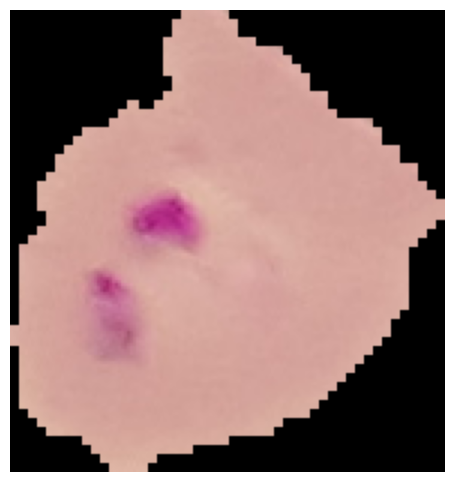

In [3]:
img_dir=os.path.join(path, 'cell_images', 'cell_images')
print(os.listdir(img_dir))
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
# Example image
x = Image.open(img_dir +
'/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_165.png')
np.array(x).shape
imshow(x)

Define your transforms for the training, validation, and testing sets

In [4]:
train_transforms = \
    transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224), # Image net standards
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    
test_transforms = \
    transforms.Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transforms = \
    transforms.Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

Load dataset

In [5]:
train_data = datasets.ImageFolder(img_dir,transform=train_transforms)
num_workers = 0

valid_size = 0.2
test_size = 0.1

num_train = len(train_data)
print(num_train)
indices = list(range(num_train))
print(indices)
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]
print(len(valid_idx), len(test_idx), len(train_idx))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
sampler=test_sampler, num_workers=num_workers)

27558
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220

Train network

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=True)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Create model

In [7]:
for param in model.parameters():
    param.require_grad = False

fc = nn.Sequential(
    nn.Linear(1024, 460),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(460, 2),
    nn.LogSoftmax(dim=1))

model.classifier = fc
criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.003)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Train and save model

In [8]:
epochs = 10
valid_loss_min = np.inf


import time


for epoch in range(epochs):
    start = time.time()
    
    # scheduler.step()
    model.train()

    train_loss = 0.0
    valid_loss = 0.0
    
    for inputs, labels in train_loader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
    train_loss += loss.item()
    
    model.eval()
    
    with torch.no_grad():
        accuracy = 0
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
        
    valid_loss += batch_loss.item()
    
    # Calculate accuracy
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    # calculate average losses
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = accuracy / len(valid_loader)
    
    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch + 1, train_loss, valid_loss, valid_accuracy))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        
    model_save_name = f"malaria_epoch_{epoch}.pt"
    path = f"models/{model_save_name}"
    torch.save(model.state_dict(), path)
    valid_loss_min = valid_loss
    
print(f"Time per epoch: {(time.time() - start):.3f} seconds")

Epoch: 1 	Training Loss: 0.000518 	Validation Loss: 0.000827 	Validation Accuracy: 0.005780
Validation loss decreased (inf --> 0.000827). Saving model ...
Epoch: 2 	Training Loss: 0.000128 	Validation Loss: 0.003920 	Validation Accuracy: 0.004955
Epoch: 3 	Training Loss: 0.000522 	Validation Loss: 0.002277 	Validation Accuracy: 0.004955
Validation loss decreased (0.003920 --> 0.002277). Saving model ...
Epoch: 4 	Training Loss: 0.000227 	Validation Loss: 0.000431 	Validation Accuracy: 0.005780
Validation loss decreased (0.002277 --> 0.000431). Saving model ...
Epoch: 5 	Training Loss: 0.000409 	Validation Loss: 0.001382 	Validation Accuracy: 0.005780
Epoch: 6 	Training Loss: 0.000659 	Validation Loss: 0.002171 	Validation Accuracy: 0.004955
Epoch: 7 	Training Loss: 0.000405 	Validation Loss: 0.000045 	Validation Accuracy: 0.005780
Validation loss decreased (0.002171 --> 0.000045). Saving model ...
Epoch: 8 	Training Loss: 0.000265 	Validation Loss: 0.000808 	Validation Accuracy: 0.0049

Load model

In [1]:
def load_input_image(img_path):
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

def predict_malaria(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

/tmp/ipykernel_9844/1949661069.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/malaria_epoch_9.pt', map_location=torch.device('

/home/dynokostya/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images
Parasitized


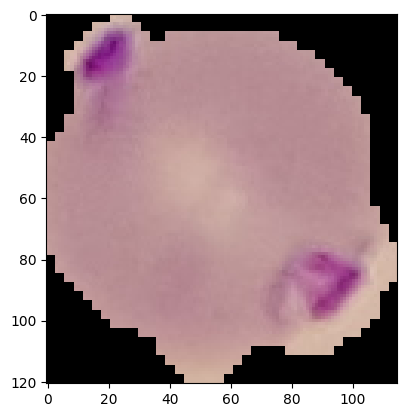

Parasitized


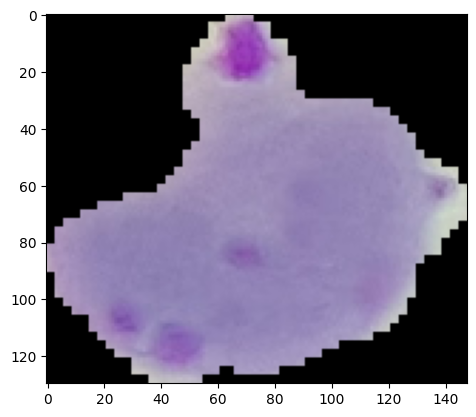

Uninfected


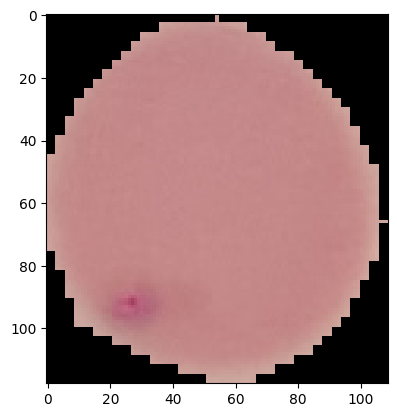

Uninfected


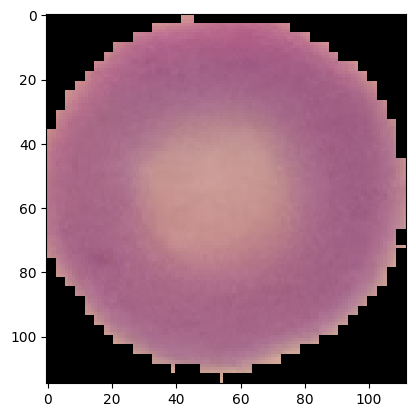

Uninfected


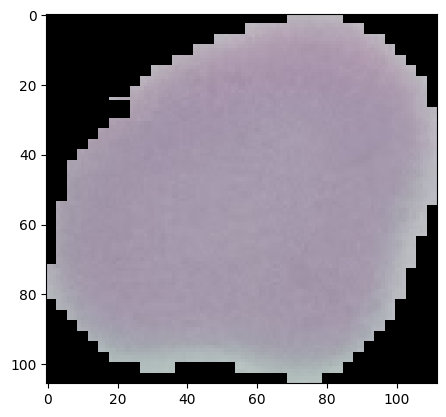

Uninfected


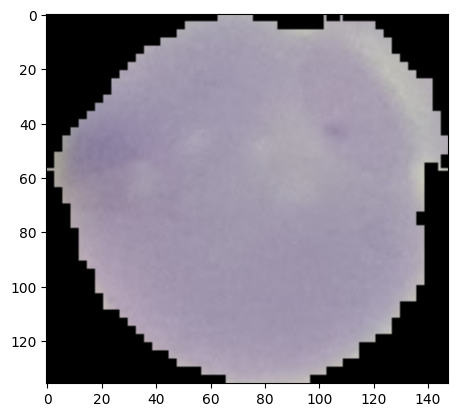

In [13]:
from glob import glob
from PIL import Image
import numpy as np
import os
import kagglehub
from termcolor import colored
import matplotlib.pyplot as plt
from torchvision import models, transforms
import torch.nn as nn
import torch

model = models.densenet121(weights=None)
model.classifier = nn.Sequential(
    nn.Linear(1024, 460),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(460, 2),
    nn.LogSoftmax(dim=1)
)
model.load_state_dict(torch.load('models/malaria_epoch_9.pt', map_location=torch.device('cpu')))
model.eval()

class_names=['Parasitized','Uninfected']
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")
img_dir = os.path.join(path, 'cell_images', 'cell_images')
print(img_dir)
inf = np.array(glob(img_dir + "/Parasitized/*"))
uninf = np.array(glob(img_dir + "/Uninfected/*"))

for i in range(3):
    img_path=inf[i]
    img = Image.open(img_path)
    
    if predict_malaria(model, class_names, img_path) == 'Parasitized':
        print(colored('Parasitized', 'green'))
    else:
        print(colored('Uninfected', 'red'))
        
    plt.imshow(img)
    plt.show()
        
for i in range(3):
    img_path=uninf[i]
    img = Image.open(img_path)
    
    if predict_malaria(model, class_names, img_path) == 'Uninfected':
        print(colored('Uninfected', 'green'))
    else:
        print(colored('Parasitized', 'red'))
    
    plt.imshow(img)
    plt.show()

Improving model

In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import os
import kagglehub

path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")
print(path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/dynokostya/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


In [15]:
train_transforms = transforms.Compose([transforms.Resize((120, 120)),
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

image_dir = os.path.join(path, 'cell_images', 'cell_images')
train_set = datasets.ImageFolder(image_dir, transform=train_transforms)

In [ ]:
test_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)

test_split = int(np.floor((test_size) * num_train))
test_index, train_index = indices[:test_split - 1], indices[test_split - 1:]

train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)

train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=104)
test_loader = DataLoader(train_set, sampler=test_sampler, batch_size=58)
print("Images in Test set: {}\nImages in Train set: {}".format(len(test_index), len(train_index)))

Images in Test set: 5510
Images in Train set: 22048


Create CNN model. Used batch norm, ReLU as activation.

In [17]:
classes=['infected','uninfected']

class MosquitoNet(nn.Module):
    
    def __init__(self):
        super(MosquitoNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
            
        self.fc1 = nn.Linear(64*15*15, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.drop = nn.Dropout2d(0.2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)    # flatten out a input for Dense Layer
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc3(out)
        
        return out

Left with Adam as good optimizer for this task

In [18]:
model = MosquitoNet()
model.to(device)
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

MosquitoNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=14400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=12

In [19]:
num_epochs = 20
batch_size = 100 

for epoch in range(num_epochs):
    train_loss = 0.
    model.train() 
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        train = images.view(-1, 3, 120, 120)
        outputs = model(train)
        
        optimizer.zero_grad()
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_size
     
    print("Epoch: {}, Loss: {:.4f}".format(epoch + 1, train_loss / len(train_loader.dataset)))

torch.save(model.state_dict(), "models/malaria_custom.pt")

/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1, Loss: 0.3785
Epoch: 2, Loss: 0.1549
Epoch: 3, Loss: 0.1315
Epoch: 4, Loss: 0.1210
Epoch: 5, Loss: 0.1138
Epoch: 6, Loss: 0.1098
Epoch: 7, Loss: 0.1092
Epoch: 8, Loss: 0.1045
Epoch: 9, Loss: 0.1004
Epoch: 10, Loss: 0.0998
Epoch: 11, Loss: 0.1003
Epoch: 12, Loss: 0.0958
Epoch: 13, Loss: 0.0917
Epoch: 14, Loss: 0.0917
Epoch: 15, Loss: 0.0938
Epoch: 16, Loss: 0.0917
Epoch: 17, Loss: 0.0877
Epoch: 18, Loss: 0.0872
Epoch: 19, Loss: 0.0871
Epoch: 20, Loss: 0.0844


Test model

In [20]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
actual = []
predict = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 96.53%

Accuracy of infected :  95.97%   [2620 / 2730]
Accuracy of uninfected :  97.09%   [2699 / 2780]


Solve the lungs

In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:05<00:00, 37.4MB/s]

Extracting files...


Path to dataset files: /home/dynokostya/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


Import libraries

In [22]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import VGG16_Weights
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import shutil
from PIL import Image
from tqdm import tqdm

In [26]:
import os

# dataset path
path = os.path.join(path, 'chest_xray')
dataset_path = os.path.join(path, 'chest_xray')
train_data = os.path.join(path, 'train')
test_data = os.path.join(path, 'test')
val_data = os.path.join(path, 'val')

# two classes
normal = "NORMAL"
pneumonia = "PNEUMONIA"

# train data
normal_train = len(os.listdir(f"{train_data}/{normal}"))
pneumonia_train = len(os.listdir(f"{train_data}/{pneumonia}"))

# test data
normal_test = len(os.listdir(f"{test_data}/{normal}"))
pneumonia_test = len(os.listdir(f"{test_data}/{pneumonia}"))

# val data
normal_val = len(os.listdir(f"{val_data}/{normal}"))
pneumonia_val = len(os.listdir(f"{val_data}/{pneumonia}"))

# check the directory length's
print(f"Length of the train {normal} folder: {normal_train}")
print(f"Length of the train {pneumonia} folder: {pneumonia_train}")
print(f"Length of the test {normal} folder: {normal_test}")
print(f"Length of the test {pneumonia} folder: {pneumonia_test}")
print(f"Length of the val {normal} folder: {normal_val}")
print(f"Length of the val {pneumonia} folder: {pneumonia_val}")

print(f"\n Total dataset length: {normal_train + normal_test + normal_val + pneumonia_train + pneumonia_test + pneumonia_val}")

Length of the train NORMAL folder: 1342
Length of the train PNEUMONIA folder: 3876
Length of the test NORMAL folder: 234
Length of the test PNEUMONIA folder: 390
Length of the val NORMAL folder: 9
Length of the val PNEUMONIA folder: 9

 Total dataset length: 5860


Balance the dataset

In [31]:
os.mkdir("./data/lungs")
# train directory
os.mkdir("./data/lungs/train")
os.mkdir("./data/lungs/train/NORMAL")
os.mkdir("./data/lungs/train/PNEUMONIA")

# test directory
os.mkdir("./data/lungs/test")
os.mkdir("./data/lungs/test/NORMAL")
os.mkdir("./data/lungs/test/PNEUMONIA")

# val directory
os.mkdir("./data/lungs/val")
os.mkdir("./data/lungs/val/NORMAL")
os.mkdir("./data/lungs/val/PNEUMONIA")

In [32]:
src_data = "./data/lungs"

In [33]:
train_set_01 = os.listdir(f"{train_data}/{normal}")
fnames = [file for file in train_set_01[0:200]]

for file in fnames:
    src = os.path.join(f"{train_data}/{normal}", file)
    dst = os.path.join(f"{src_data}/train/NORMAL", file)
    shutil.copyfile(src, dst)

train_set_02 = os.listdir(f"{train_data}/{pneumonia}")
fnames = [file for file in train_set_02[0:200]]

for file in fnames:
    src = os.path.join(f"{train_data}/{pneumonia}", file)
    dst = os.path.join(f"{src_data}/train/PNEUMONIA", file)
    shutil.copyfile(src, dst)
    
test_set_01 = os.listdir(f"{test_data}/{normal}")
fnames = [file for file in test_set_01[0:50]]

for file in fnames:
    src = os.path.join(f"{test_data}/{normal}", file)
    dst = os.path.join(f"{src_data}/test/NORMAL", file)
    shutil.copyfile(src, dst)
    
test_set_02 = os.listdir(f"{test_data}/{pneumonia}")
fnames = [file for file in test_set_02[0:50]]

for file in fnames:
    src = os.path.join(f"{test_data}/{pneumonia}", file)
    dst = os.path.join(f"{src_data}/test/PNEUMONIA", file)
    shutil.copyfile(src, dst)

In [34]:
data_test = "./data/lungs/test"
data_train = "./data/lungs/train"

data_normal_train = os.listdir(f"{data_train}/NORMAL")
data_pneumonia_train = os.listdir(f"{data_train}/PNEUMONIA")
data_normal_test = os.listdir(f"{data_test}/NORMAL")
data_pneumonia_test = os.listdir(f"{data_test}/PNEUMONIA")

print(f"Length of the train NORMAL: {len(data_normal_train)}")
print(f"Length of the train PNEUMONIA: {len(data_pneumonia_train)}")
print(f"Length of the test NORMAL: {len(data_normal_test)}")
print(f"Length of the test PNEUMONIA: {len(data_pneumonia_test)}")

Length of the train NORMAL: 200
Length of the train PNEUMONIA: 200
Length of the test NORMAL: 50
Length of the test PNEUMONIA: 50


Define parameters

In [36]:
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)
lr = 0.005
num_classes = 2
num_epochs = 5

Load data

In [38]:
# method to data loaders
def data_creation():
    
    # transforms for the images
    transform = transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(TARGET_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # create an Image Folder
    trainset = datasets.ImageFolder(
        root=data_train,
        transform=transform
    )
    
    validset = datasets.ImageFolder(
        root=val_data,
        transform=transform
    )
    
    testset = datasets.ImageFolder(
        root = data_test,
        transform = transform
    )
    
    # prepare the data loaders
    train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)
    
    return train_loader, test_loader, val_loader

train_loader, test_loader, val_loader = data_creation()
lst = list(train_loader)
len(lst[0][0])

64

Load pretrained VGG16 model

In [40]:
model = models.vgg16(weights="DEFAULT")
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [42]:
parameters = model.parameters()

for param in parameters:
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.classifier[6].out_features

cuda


1000

In [43]:
# set the avgpool features
model.avgpool = nn.Identity()

num_features = model.classifier[6].in_features

print(num_features)

features = list(model.classifier.children())[:-1] # remove the last layer

# add the new layer at the end of the features
features.extend([nn.Linear(num_features, 2)])

model.classifier = nn.Sequential(*features)

model.to(device)

4096


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
valid_losses = []

# create an training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # move the data to the appropirate device
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # gradient descent
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    print(f"Epoch {epoch}, step {num_epochs} loss: {loss.item():.4f}")
    
    # Validation
    model.eval()
    for data, target in val_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

torch.save(model.state_dict(), "models/lungs_custom.pt")

100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch 0, step 5 loss: 0.2943
Epoch: 0 	Training Loss: 0.450205 	Validation Loss: 0.178175


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch 1, step 5 loss: 0.1958
Epoch: 1 	Training Loss: 0.198125 	Validation Loss: 0.160634


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch 2, step 5 loss: 0.4092
Epoch: 2 	Training Loss: 0.150044 	Validation Loss: 0.227327


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch 3, step 5 loss: 0.0951
Epoch: 3 	Training Loss: 0.120873 	Validation Loss: 0.730046


100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch 4, step 5 loss: 0.0296
Epoch: 4 	Training Loss: 0.093376 	Validation Loss: 0.401788


Accuracy

In [46]:
def check_accuracy(loader: DataLoader, model) -> float:
    num_correct = 0
    num_samples = 0

    # set the model into inference mode
    model.eval()

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

train = check_accuracy(train_loader, model)
test = check_accuracy(test_loader, model)
print(f"Accuracy on training set: {train*100:.2f}")
print(f"Accuracy on testing set: {test*100:.2f}")

Accuracy on training set: 79.00
Accuracy on testing set: 79.00


У висновках обґрунтувати вибір оптимальної нейронної мережі для
задачі виявлення малярії та рентгенівських знімків легенів. Зробити
відповідні висновки, щодо отриманих результатів

1. Як проводиться збереження коефіцієнтів моделі у PyTorch?
2. Як завантажити коефіцієнти попередньо збереженої моделі у
PyTorch?

Висновки: для задачі з малярією було створено модель з точністю 96%. Було підібрано оптимальні параметри експериментальними методами. Для задачі класифікації легень було використано transfer learning та досягнуто точності у 79%.

1. Як проводиться збереження коефіцієнтів моделі у PyTorch?

Для збереження коефіцієнтів моделі у PyTorch використовується функція `torch.save()`. Наприклад, щоб зберегти модель, можна використати наступний код:

torch.save(model.state_dict(), "path_to_save_model.pth")


2. Як завантажити коефіцієнти попередньо збереженої моделі у PyTorch?

Для завантаження коефіцієнтів попередньо збереженої моделі у PyTorch використовується функція `torch.load()` та метод `load_state_dict()`. Наприклад, щоб завантажити модель, можна використати наступний код:

model.load_state_dict(torch.load("path_to_save_model.pth"))
model.eval()  # Перевести модель в режим оцінки
